**CvC-cleanicDB and Kavasir-seg**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
# Data pre-processing
meta_data = pd.read_csv("main_metadata.csv")
meta_data

,Unnamed: 0,image_path,mask_path
0,0,Polyp_dataset/PNG/Original/1.png,Polyp_dataset/PNG/Ground Truth/1.png
1,1,Polyp_dataset/PNG/Original/10.png,Polyp_dataset/PNG/Ground Truth/10.png
2,2,Polyp_dataset/PNG/Original/100.png,Polyp_dataset/PNG/Ground Truth/100.png
3,3,Polyp_dataset/PNG/Original/101.png,Polyp_dataset/PNG/Ground Truth/101.png
4,4,Polyp_dataset/PNG/Original/102.png,Polyp_dataset/PNG/Ground Truth/102.png
...,...,...,...
1608,1608,seg-data/images/cju7dff9529h208503w60lbil.jpg,seg-data/masks/cju7dff9529h208503w60lbil.jpg
1609,1609,seg-data/images/cju2p0eveqtdc0835gpi3p93i.jpg,seg-data/masks/cju2p0eveqtdc0835gpi3p93i.jpg
1610,1610,seg-data/images/cju1hhj6mxfp90835n3wofrap.jpg,seg-data/masks/cju1hhj6mxfp90835n3wofrap.jpg
1611,1611,seg-data/images/cju2yi9tz8vky0801yqip0xyl.jpg,seg-data/masks/cju2yi9tz8vky0801yqip0xyl.jpg


In [3]:
def load_data(meta_data, target_size=(256, 256)):
    image_paths = np.array(meta_data["image_path"])
    mask_paths = np.array(meta_data["mask_path"])

    images, masks = [], []

    for img_path, mask_path in zip(image_paths, mask_paths):
       
        
        # Check if the file exists before reading
        if not os.path.isfile(img_path) or not os.path.isfile(mask_path):
            print(f"❌ Skipping missing file: {img_path} or {mask_path}")
            continue

        # Read the image
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"❌ Failed to load image: {img_path}")
            continue

        if mask is None:
            print(f"❌ Failed to load mask: {mask_path}")
            continue

        # Convert 4-channel PNG (RGBA) to 3-channel (RGB)
        if len(image.shape) == 3 and image.shape[-1] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        # Resize only if image and mask are valid
        try:
            image = cv2.resize(image, target_size)
            mask = cv2.resize(mask, target_size)
        except Exception as e:
            print(f"❌ Error resizing: {img_path} or {mask_path} | {str(e)}")
            continue

        # Normalize images and masks
        image = image / 255.0
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for compatibility

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f"✅ Loaded {len(images)} images and {len(masks)} masks.")
    return images, masks


        

In [4]:
X,Y = load_data(meta_data)

❌ Skipping missing file: seg-data/images/.ipynb_checkpoints or seg-data/masks/.ipynb_checkpoints
✅ Loaded 1612 images and 1612 masks.


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, shuffle = True,random_state= 10)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.08, shuffle = True, random_state = 10)

print("x_train size:", len(x_train))
print("x_test size:", len(x_test))
print("x_val size:", len(x_val))

x_train size: 1185
x_test size: 323
x_val size: 104


In [6]:
#Min_pool
def min_pooling_2d(x, pool_size=(2, 2), strides=(2, 2), padding='VALID'):
    return -tf.nn.max_pool(-x, ksize=pool_size, strides=strides, padding=padding.upper())

# Lambda wrapper for MinPooling2D
class MinPooling2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='VALID', **kwargs):
        super(MinPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return min_pooling_2d(inputs, self.pool_size, self.strides, self.padding)

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            input_shape[1] // self.strides[0],
            input_shape[2] // self.strides[1],
            input_shape[3],
        )
    
#feature_extenct
def feature_extenct(input, num_filters = 128):
    conv = layers.Conv2D(num_filters, (3,3), activation = 'relu', padding="same")(input)

    max_f = layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(conv)
    min_f = MinPooling2D(pool_size=(2, 2), strides=(2, 2))(conv)

    extent = layers.Add()([max_f,min_f])

    norm = layers.BatchNormalization()(extent)
    return norm


In [8]:
# Use GPU for TensorFlow operations
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Your TensorFlow code here

    def munet_model(input_shape):
        inputs = layers.Input(input_shape)
#Encoder
        
        conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(inputs)
        f = feature_extenct(conv1, num_filters = 128)
        
        conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(f)
        conv_dl = layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', dilation_rate = (2,2),kernel_initializer = 'he_normal')(conv2)
        pool2 = layers.AveragePooling2D(pool_size=(2, 2), strides = (2,2))(conv_dl)

        conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(pool2)
        pool3 = MinPooling2D(pool_size=(2, 2), strides = (2,2))(conv3)

# Bottleneck
        
        conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(pool3)
        conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

# Decoder
        
        up1 = layers.UpSampling2D(size=(2, 2))(conv4)
        up1 = layers.concatenate([up1, conv3], axis=-1)
        conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(up1)

        up2 = layers.UpSampling2D(size=(2, 2))(conv5)
        up2 = layers.concatenate([up2, conv2], axis=-1)
        conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(up2)

        up3 = layers.UpSampling2D(size=(2, 2))(conv6)
        up3 = layers.concatenate([up3, conv1], axis=-1)
        conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(up3)

        output = layers.Conv2D(1, (1, 1), activation='sigmoid',kernel_initializer = 'glorot_uniform')(conv7)

        model = models.Model(inputs=inputs, outputs=output)

        return model

# Create an instance of the U-Net model
model = munet_model(input_shape=(256, 256, 3))

# Display the model summary
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     73,856 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ min_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MinPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │ min_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │    295,168 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (AveragePooling2D)  │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ average_pooling2… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ min_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MinPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ min_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_10[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0

 Total params: 6,971,905 (26.60 MB)

 Trainable params: 6,971,649 (26.59 MB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
# IoU (Jaccard Index) for Binary Segmentation
def IoU(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert to binary mask
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Dice Coefficient for Segmentation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert to binary mask
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Corrected model.compile()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use categorical_crossentropy for multi-class
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), IoU, dice_coefficient]
)


In [10]:

# Train the model
history = model.fit(x_train, y_train,batch_size = 8, epochs= 20 ,shuffle = True, validation_data=(x_val,y_val))

Epoch 1/20


2025-03-14 16:04:34.832631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


149/149 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8474 - dice_coefficient: 0.0162 - io_u: 0.0088 - loss: 0.8398 - mean_io_u: 0.4385 - val_accuracy: 0.8239 - val_dice_coefficient: 0.4002 - val_io_u: 0.2526 - val_loss: 0.3936 - val_mean_io_u: 0.4453
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.8668 - dice_coefficient: 0.0235 - io_u: 0.0131 - loss: 0.3178 - mean_io_u: 0.4385 - val_accuracy: 0.8827 - val_dice_coefficient: 0.0130 - val_io_u: 0.0071 - val_loss: 0.2817 - val_mean_io_u: 0.4453
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.8669 - dice_coefficient: 0.0377 - io_u: 0.0206 - loss: 0.2998 - mean_io_u: 0.4382 - val_accuracy: 0.8822 - val_dice_coefficient: 1.8256e-11 - val_io_u: 1.8256e-11 - val_loss: 0.2783 - val_mean_io_u: 0.4453
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.8576 - dice_coefficient: 0.0494 - io_u: 0.0271 - loss: 0.3076 - mean_io_u: 0.4338 - val_accuracy: 0.8834 - val_dice_coefficient: 0.0236 - val

In [11]:
results = model.evaluate(x_test, y_test)
metrics_names = ["Loss", "Accuracy", "Mean IoU", "IoU", "Dice Coefficient"]  # Adjust based on your model
results_dict = dict(zip(metrics_names, results))

for metric, value in results_dict.items():
    print(f"{metric}: {value:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9193 - dice_coefficient: 0.6593 - io_u: 0.4946 - loss: 0.2259 - mean_io_u: 0.4379
Loss: 0.2272
Accuracy: 0.9181
Mean IoU: 0.4363
IoU: 0.5243
Dice Coefficient: 0.6835


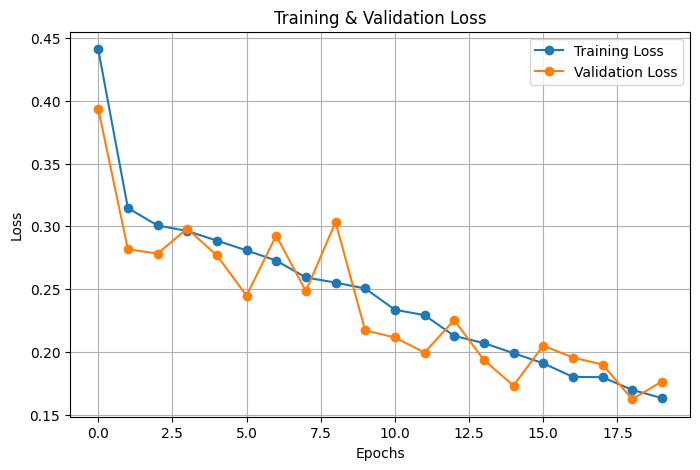

In [12]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


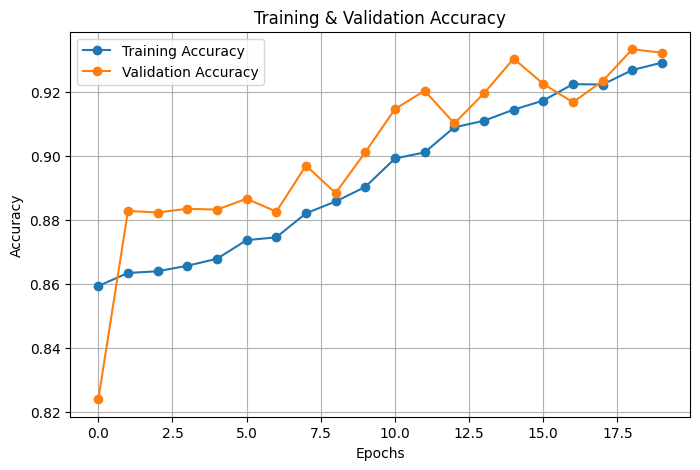

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


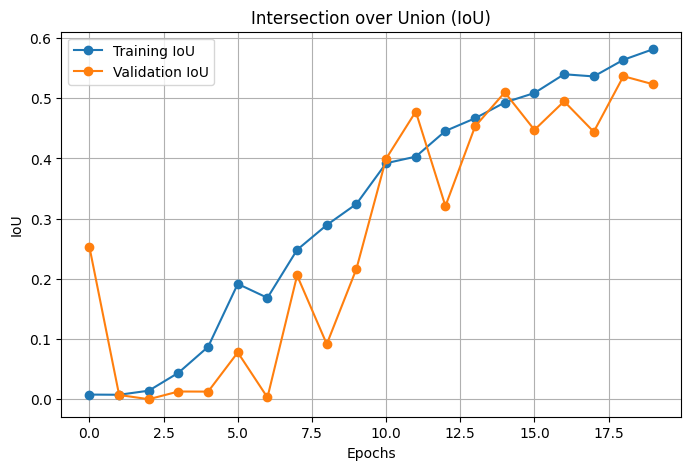

In [14]:


train_iou = history.history['io_u']
val_iou = history.history['val_io_u']
    
    

    # IoU Plot
plt.figure(figsize=(8, 5))
plt.plot(train_iou, label='Training IoU', marker='o')
plt.plot(val_iou, label='Validation IoU', marker='o')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU)')
plt.legend()
plt.grid(True)
plt.show()

    


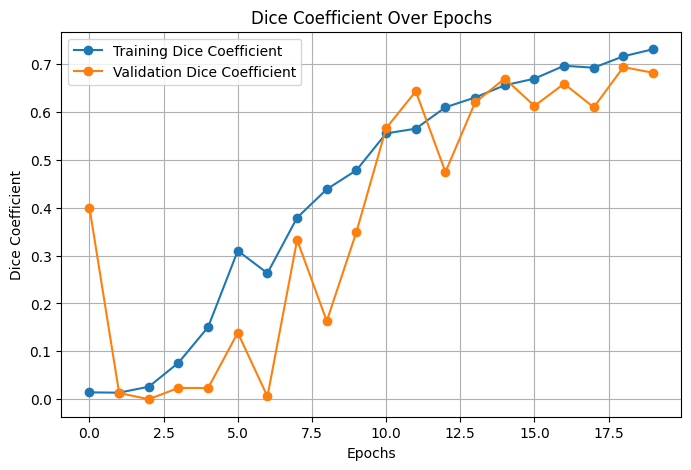

In [15]:
train_dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']
# Dice Coefficient Plot
plt.figure(figsize=(8, 5))
plt.plot(train_dice, label='Training Dice Coefficient', marker='o')
plt.plot(val_dice, label='Validation Dice Coefficient', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Accuracy: 0.9254
Precision: 0.7910
Recall: 0.5733
IoU: 0.4979
Confusion Matrix:
[[18022745   413699]
 [ 1165698  1565986]]


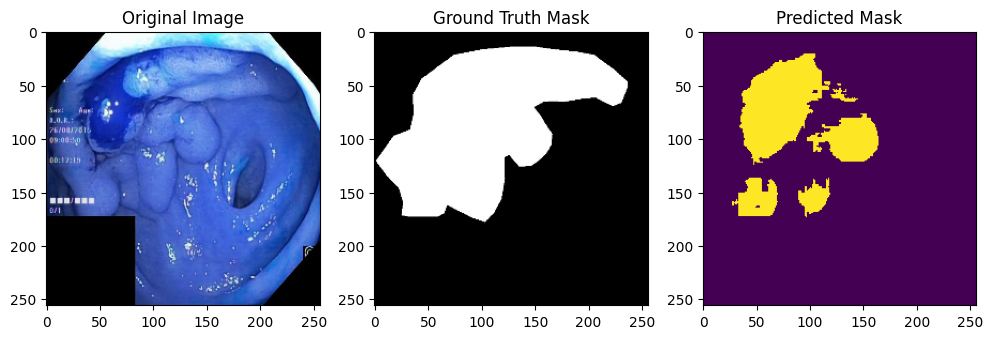

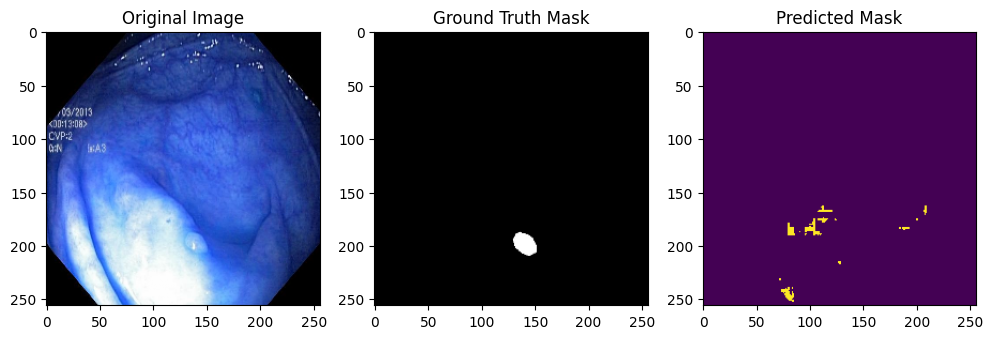

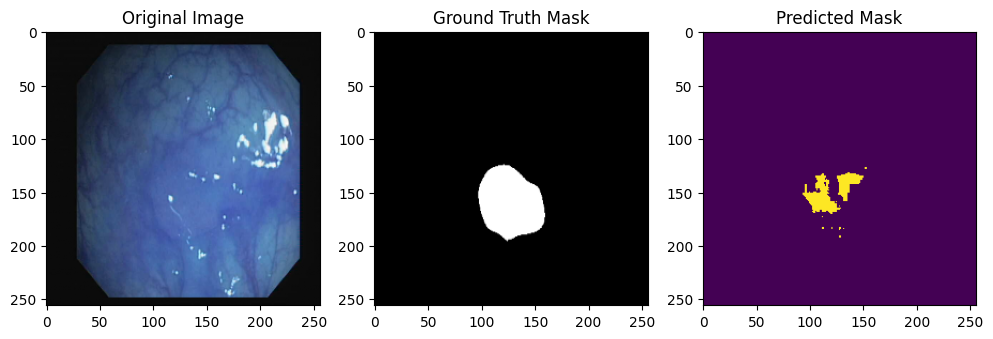

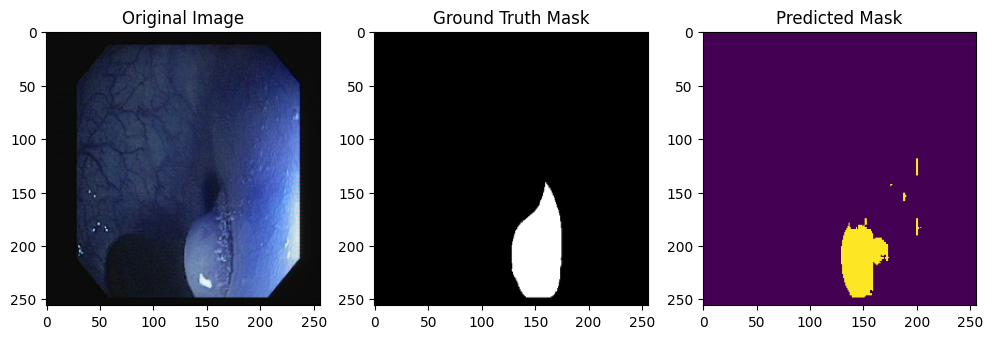

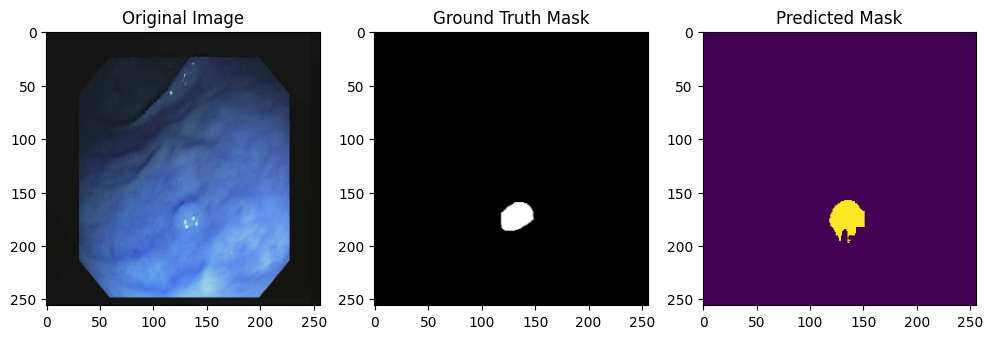

In [16]:
y_pred = model.predict(x_test)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.preprocessing import image



# Threshold predicted masks (assuming binary segmentation)
y_pred_binary = (y_pred > 0.5)

y_test_flat = y_test.flatten().astype(np.uint8)
y_pred_flat = y_pred_binary.flatten().astype(np.uint8)

# Calculate metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)

# Intersection over Union (IoU) or Jaccard Index
intersection = np.sum(y_test_flat * y_pred_flat)
union = np.sum((y_test_flat + y_pred_flat) > 0)
iou = intersection / union

# Confusion matrix
conf_mat = confusion_matrix(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'IoU: {iou:.4f}')
print(f'Confusion Matrix:\n{conf_mat}')

# Visualize model predictions on test images
num_samples = min(x_test.shape[0], 5)  # Visualize predictions for a few samples

for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i, :, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_binary[i, :, :, 0])
    plt.title('Predicted Mask')

    plt.show()